# Development of driving accident numbers among young drivers with the introduction of BF17
# Final report

## Introduction
In the year 2011 BF17 (Begleitetes Fahren ab 17) was introduced in whole Germany. Young people participating in this program can get a driving license already at the age of 17, one year before the regular permission age, and can drive as long as they are accompanied by an adult companion.\
The benefit of this program was said to be a reduction of driving accidents because young drivers get more expertise together with a experienced companion.

In this project I try to find out if this hope can be confirmed by looking at the number of driving accidents among young drivers in combination with the numbers of BF17 participants in the last years. The question is if a correlation can be found in those two numbers: Has a increasing number of BF17 participants lead to less driving accidents among young people?

The following questions should be answered in this project:
- Are enough young people using the BF17 program, so that a relevant influence in the accidents can be even deduced from the program?
- How did the introduction of BF17 influence the number of accidents among young drivers?

## Methods and data pipeline

### Data sources
For this project two open data sources were chosen.

The first question to be solved is if the BF17 program is really used.
This question should be solved by checking the "Fahrerlaubnisse auf Probe" (driving permits on probation), the number of new class B (normal car) driving permits at the age of 17. These can only be obtained if BF17 is used, as the normal minimum age for class B without BF17 is 18.  
These numbers are offered as Excel files from the Kraftfahrbundesamt (KBA) for the years 2017 to 2023.

Then the actual number of accidents is researched. The Statistisches Bundesamt offers the number of traffic accidents of all kinds in their Genesis Destatis data warehouse. This statistic contains all numbers of all age groups and all kinds of accidents so the needed numbers (especially accidents among young drivers but also the number of accidents in general) can be selected. Data is available from the years 2008 to 2023.
TODO: Licenses

### The data pipeline
Because of the two different sources the pipeline consists of two smaller pipelines for both sources:
The kba_pipeline.py for the number of driving permits, and destatis_pipeline.py for the destatis pipeline. By executing the main pipeline with pipeline.sh both pipelines are executed and the data is collected to one single sqlite database.

The pipeline can be executed manually with the following steps:
- Create an account for the Genesis Destatis DWH => https://www-genesis.destatis.de/genesis/online
- Enter your username and password in the respective fields in the pipeline.sh
- Prepare a Python environment with the given project/requirements.txt
- Execute the pipeline.sh
- The data of both pipelines is loaded into data/kba.sqlite 

### Extraction, transformation and cleaning steps
The following steps are done for the both pipelines:

KBA pipeline:
The data does not exist in one single Excel file, but for each year an Excel file exists. So the following steps are done for each file:
- At first the data is extracted from the KBA website by just downloading the Excel file
- The needed table of the Excel file is extracted with the openpyxl library
- The data is transformed to a pandas dataframe for easier handling
- The data frame is cleaned and transformed by the following steps:
  - All missing numbers (designated in the Excel as - or .) are replaced with proper NaNs
  - The columns are renamed and their data type is changed correctly
  - The year is added as extra column
- Finally the table is appended to the sqlite file table 'Fahrerlaubnisse'

Destatis pipeline:
The data source Genesis is very hard to handle: It suffers from occasional outages and is in general very slow. Also, a (free) account has to created on the Genesis website. Because of this the pipeline has an offline mode which reuses a once downloaded file to transform. The online mode uses the genesis_puller.py file which has the logic to access Genesis.
The following steps are done in this pipeline:
- If the destatis_pipeline.py is started with a Genesis account (Two command line params: Genesis user, Genesis password) => Online mode
  - Retrieve the data from the Genesis data warehouse by doing:
    - Send a batch request to Genesis with the needed table code so that the data is prepared on the Genesis server
    - each 15 seconds: check if the data preparation is done and pull the data if ready; else continue waiting
    - The data preparation can take up to several minutes
  - Write the pulled data into a csv (data/accidents.csv)
- If the destatis_pipeline.py is started without a Genesis account => Offline mode
  - Check if a pre downloaded data/accidents.csv exists
  - If yes: Continue with the transformation with this file
  - If no: Throw an error to the user; end of program
- Load the data from the downloaded/given csv as pandas dataframe
- Then the data is cleaned with the following steps:
  - Unnecessary header lines (because of the DWH format) are removed
  - The DWH slicing is done by removing unnecessary columns and rows (especially vehicle types which are not interesting for this project)
  - The columns are renamed and the data types are changed correctly
  - All missing numbers (designated as - or .) are replaced with proper NaNs
- Finally the dataframe is loaded into the sqlite database as own table

### Tests
To guarantee that the pipeline works also after some changes and is doing the transformation correctly, a test suite was created.
The tests can be found in test_pipeline.py, it can be executed by running pipeline.sh.
The suite currently contains 7 tests which consist of System tests for both pipelines running all steps, but also extra tests for the single transformation and cleaning steps.
The online system test of the destatis_pipeline.py also runs the genesis_puller.py which is why the Genesis account data has to be entered in the test_pipeline.py (variables GENESIS_USER and GENESIS_PASSWORD) to run this test, else it is skipped. An offline system test also exists which is executed each time.

To test the single transformation and cleaning steps mock data is used which can be found under project/test_data. Although both data sources have licenses which allow the redistribution of data, the actual data of these tables is randomized/replaced by arbitrary numbers.

A CI/CD pipeline with GitHub Actions which executes the test suite after each commit to the repository was also set up. This pipeline is only set up with the offline Genesis pipeline, the online test with pulling from the Genesis DWH is skipped. The reason for this are, as already explained:
- The long execution time of the pipeline of up to several minutes
- And the occasional errors and outages of the Genesis database, which could lead to a failing CI/CD pipeline, although the pipeline is not at fault.

## Results
In the following section the results of the data analysis are presented. The interpretation and answering the main question are done in the next section "Interpretation".

### Driving permits with BF17
At first, it is researched by how many young people the BF17 program is used.
For this the numbers of driving permits for the normal class B driving permission (PKWs) are investigated among the different age groups.


To run the following code, first execute the pipeline by doing the steps given above (Methods and data pipeline -> The data pipeline)

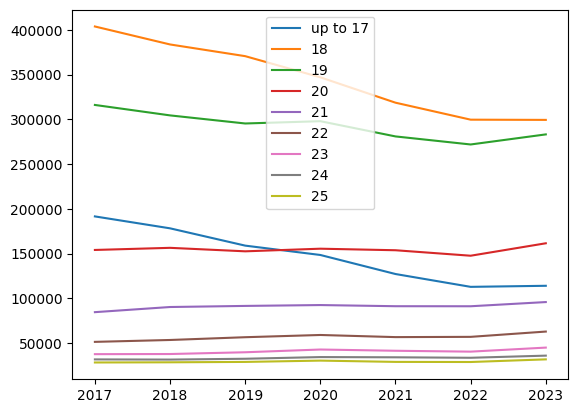

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_sql_table('Fahrerlaubnisse', 'sqlite:///../data/kba.sqlite')

filtered = df[df["Alter"].isin(["bis 17", "18", "19", "20", "21", "22", "23", "24", "25"])]
filtered = filtered.sort_values(by=["Jahr"])

years = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]
plt.plot(years, (filtered[filtered["Alter"] == "bis 17"])["B"], label="up to 17")
plt.plot(years, (filtered[filtered["Alter"] == "18"])["B"], label="18")
plt.plot(years, (filtered[filtered["Alter"] == "19"])["B"], label="19")
plt.plot(years, (filtered[filtered["Alter"] == "20"])["B"], label="20")
plt.plot(years, (filtered[filtered["Alter"] == "21"])["B"], label="21")
plt.plot(years, (filtered[filtered["Alter"] == "22"])["B"], label="22")
plt.plot(years, (filtered[filtered["Alter"] == "23"])["B"], label="23")
plt.plot(years, (filtered[filtered["Alter"] == "24"])["B"], label="24")
plt.plot(years, (filtered[filtered["Alter"] == "25"])["B"], label="25")
plt.legend()
plt.show()


This graph shows the number of new class B licenses (probation) from 2017 to 2023 among the different age groups from age 17 to 25.
Following observations can be done:
- The amount of new driving licenses is in general steadily sinking especially until 2022
- Most licenses in probation are by 18-year-olds. As the probation takes two years, this number consists of young people which did BF17 (and are now on the second year of their probation) AND people who gained their license only with 18 without BF17.
- The B (17) and B (18) graphs show that about half of the 18-year-old new drivers have done BF17 which is a significant amount.
- In the last years the amount of BF17 is reduced a bit (shown by the decreasing B (17) curve, and the increasing B (18) curve)
- From 21 years on there are only very few new driving licenses. Most people decide to do their class B license between 17 and 20.

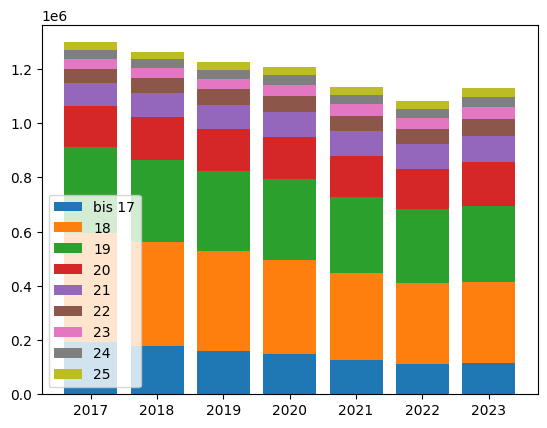

In [24]:
plt.figure()

ages = ["bis 17", "18", "19", "20", "21", "22", "23", "24", "25"]
sums = [0, 0, 0, 0, 0, 0, 0]
for i in range(0, len(ages)):
    values = (filtered[filtered["Alter"] == ages[i]])["B"]
    plt.bar(years, values, 
            bottom=sums, label=ages[i])
    sums = [x + y for x, y in zip(sums, values)]
    
plt.legend()
plt.show()

This bar graph shows the following facts:
- The general count of new driving licenses is sinking in recent years (except 2023, but that may still be a COVID effect as many people could not/did not want to start with their driving training)
- It is better visible that the group of 17-year-olds with driving license is steadily sinking while other age groups (especially 19 and 20) stay relatively constant

### Driving accidents among young people
Next the amount of driving accidents over the last years among the different age groups is investigated.


/var/folders/5b/6x75ry_x0571jsb9gmzl77yh0000gn/T/ipykernel_3047/2701365708.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby("year").sum()


<Axes: xlabel='year'>

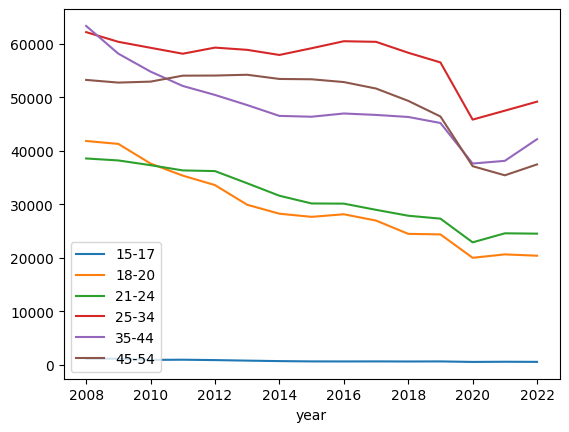

In [25]:
import pandas as pd
import matplotlib as plt

df = pd.read_sql_table('accidents', 'sqlite:///../data/kba.sqlite')
df = df.fillna(0)
df = df.groupby("year").sum()

df.plot()

This graph shows the number of driving accidents among different age groups over the last years with the following conditions:
- The respective person was the main cause of the accident, not just a "participant"
- These are only accidents caused by normal personal cars (Personenkraftwagen), LKWs (Güterkraftfahrzeuge), and agricultural vehicles (Landwirtschaftliche Zugmaschinen), as only these accidents could really be caused by young people, and could be influenced greatly by BF17. Especially accidents by busses are filtered out as these can only be caused by people of age 24 and older. Also, accidents caused by bikes and pedestrians are filtered out.
- All kinds of accidents are investigated here (accidents with only property damage, accidents with injured people...)
- All locations are considered (in cities, outside of cities, on highways...)
(This data filtering was already done by the data pipeline itself as the other data from the Genesis database is not needed here)

The following results can be deduced from this graph:
